### Import bibliotek


In [6]:
# !pip install interpret
# !pip install mlxtend

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

from sklearn.ensemble import RandomForestClassifier

from interpret.blackbox import LimeTabular
from interpret import show

np.random.seed(222)

### Wczytanie danych

In [4]:
df = pd.read_csv("stand_LIME.csv", index_col=0)
df.head()

,x1_s,x2_s,y
0,-0.628185,0.782535,0
1,-0.676717,0.759066,0
2,-0.725250,0.744985,0
3,-0.773783,0.726210,0
4,-0.844716,0.702741,0


### Przygotowanie danych


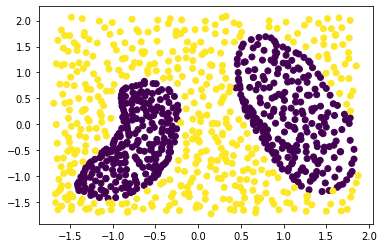

In [5]:
X = df[['x1_s','x2_s']].values
y = df['y'].values
plt.scatter(X[:,0],X[:,1], c=y); # cmap = 'Blues'

Klasa `0` to kształty, klasa `1` to tło.

### Budowa klasyfikatora

In [6]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
y_hat = rf.predict(X)

#### Ocena jakości klasyfikacji

1.0


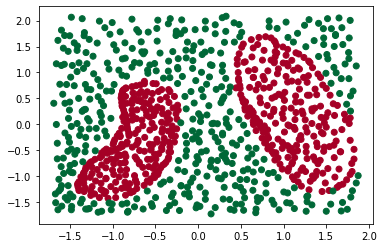

In [7]:
print(rf.score(X, y))
plt.scatter(X[:,0],X[:,1], c=y_hat, cmap="RdYlGn");

#### Wykreślenie obszarów decyzyjnych klasyfikatora z prezentacją wybranego przypadku

Jan należy do klasy [1]


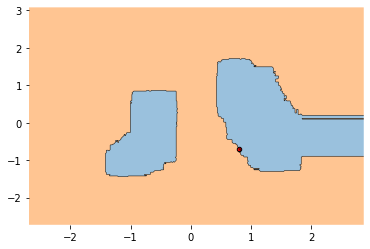

In [8]:
regiony = {'edgecolor': None, 'alpha': 0.0}
obserwacja = {'s': 20, 'label': 'Jan', 'c': 'r'}
jan = np.array([[0.8, -0.7]])
jan_forest = rf.predict(jan)
print(f'Jan należy do klasy {jan_forest}')


plot_decision_regions(X, y, clf=rf, legend = False,
                      X_highlight=jan,
                      scatter_kwargs=regiony,
                      scatter_highlight_kwargs=obserwacja);

# *Local Interpretable Model-agnostic Explanations* (**LIME**) 

$$\hat{g} = arg\min_{g\in G} \mathcal{L}\left\{ f, g, \pi_x \right\} + \Omega(g)$$

$\hat{g}$ - konkretna obserwacja,

$g\in G$ - model należący do klasy modeli $G$, klasy potencjalnie interpretowalnych modeli takich jak: regresja liniowa, drzewa decyzyjne, klasyfikatory regułowe,

$f$ - model złożony typu *blackbox*,

$\pi_x$ - sąsiectwo konkretnej obserwacji (*proximity*) - najczęściej wyrażane miarą odległości,

$\mathcal{L}$ - poszukiwane "dobre dopasowanie" modelu $f$ przez model $g$ w sąsiedztwie $\pi_x$

$\Omega(g)$ - służy uregulowaniu złożoności naszego prostego modelu zastępczego $g$ (miara złożoności). Na przykład dla regresji liniowej warunkiem byłoby ustawienie wag dla niektórych zmiennych na $0$ (aby uprościć iterpretację wprowadzając do modelu tylko kilka $x_i$), dla drzew decyzyjnych ustawienie małej głębokości drzewa,

$arg\min_{g\in G}$ - to problem minimalizacji, minimalizujemy dwie funkcje straty, ze względu na model $g$, przybliżamy więc złożony model w lokalnym obszarze do modelu prostego z dodatkowym warunkiem znalezienie modelu jak najprostszego.



### Krok 1.

Wygenerowanie przypadkowych zakłóceń (*perturbation*) wokół wyjaśnianej obserwacji


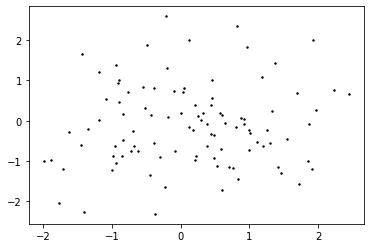

In [9]:
num_perturb = 100
np.random.seed(222) 
X_lime = np.random.normal(0,1,size=(num_perturb,X.shape[1]))

plt.scatter(X_lime[:,0],X_lime[:,1],s=2,c="black");

### Krok 2.

Wykorzystanie klasyfikatora do przewidywania klasy nowo wygenerowanego zbioru danych

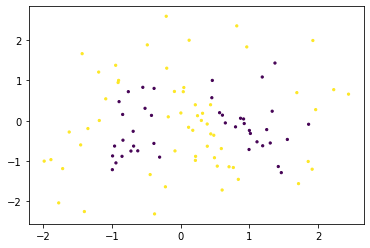

In [10]:
y_lime = rf.predict(X_lime)

plt.scatter(X_lime[:,0],X_lime[:,1],s=5, c=y_lime);

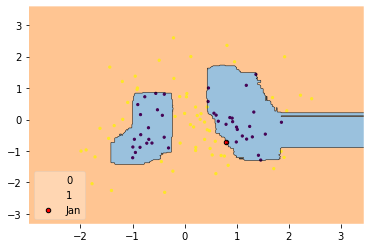

In [11]:
plot_decision_regions(X_lime, y_lime, clf=rf, legend=3,
                      X_highlight=jan,
                      scatter_kwargs=regiony,
                      scatter_highlight_kwargs=obserwacja)
plt.scatter(X_lime[:,0],X_lime[:,1], s=5, c=y_lime);

### Krok 3.

Obliczenie odległości między wyjaśnianą obserwacją a każdym zakłóceniem oraz obliczenie wagi ich ważności (*importance*)

In [12]:
odleglosc = np.sum((jan - X_lime)**2, axis=1)  # odległość euklidesowa

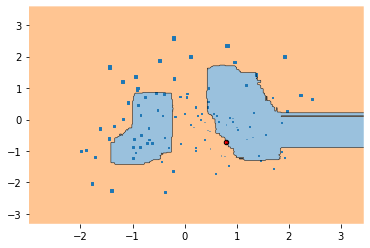

In [13]:
plot_decision_regions(X_lime, y_lime, clf=rf, legend=False,
                      X_highlight=jan,
                      scatter_kwargs=regiony,
                      scatter_highlight_kwargs=obserwacja)
plt.scatter(X_lime[:,0], X_lime[:,1], s = odleglosc,  marker="s")

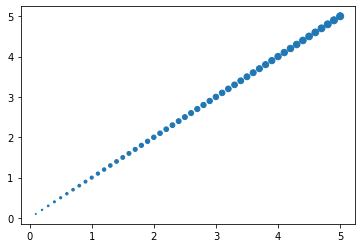

In [14]:
odleg = np.arange(0.1, 5.1, 0.1)
plt.scatter(odleg, odleg, s=odleg*10)

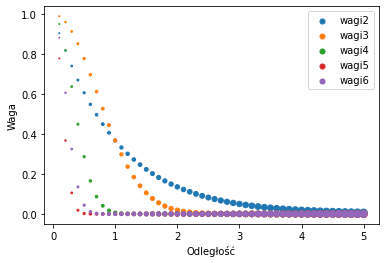

In [15]:
promien = 0.2
wagi1 = np.exp(odleg)
wagi2 = np.exp(-(odleg))
wagi3 = np.exp(-(odleg**2))
wagi4 = np.exp(-(odleg**2)/(promien))
wagi5 = np.exp(-(odleg**2)/(promien**2))
wagi6 = np.sqrt(np.exp(-(odleg**2)/(promien**2)))

# plt.scatter(odleg, wagi1, s=odleg*10)
plt.scatter(odleg, wagi2, s=odleg*10)
plt.scatter(odleg, wagi3, s=odleg*10)
plt.scatter(odleg, wagi4, s=odleg*10)
plt.scatter(odleg, wagi5, s=odleg*10)
plt.scatter(odleg, wagi6, s=odleg*10)
plt.legend(['wagi2','wagi3','wagi4','wagi5','wagi6'])
plt.xlabel('Odległość')
plt.ylabel('Waga');

In [16]:
promien = 0.2
wagi = np.array(np.sqrt(np.exp(-(odleglosc**2)/(promien**2)))) # Kernel function

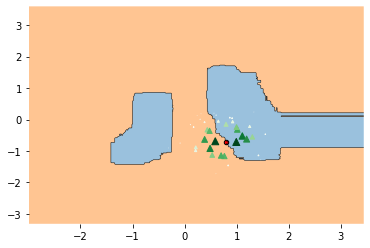

In [17]:
plot_decision_regions(X_lime, y_lime, clf=rf, legend=False,
                      X_highlight=jan,
                      scatter_kwargs=regiony,
                      scatter_highlight_kwargs=obserwacja)

plt.scatter(X_lime[:, 0], X_lime[:, 1],
            s=wagi * 50, c=wagi, cmap="Greens", marker="^");
# plt.scatter(X_lime[y_lime == 0, 0], X_lime[y_lime == 0, 1],
#             s=wagi[y_lime == 0] * 50, c=wagi[y_lime == 0], cmap="Greens", marker="_")
# plt.scatter(X_lime[y_lime == 1, 0], X_lime[y_lime == 1, 1],
#             s=wagi[y_lime == 1] * 50, c=wagi[y_lime == 1], cmap="Greens", marker="+");

### Krok 4.

Dopasowanie prostszego i łatwiejszego w interpretacji modelu (tutaj regresji liniowej) do nowo wygenerowanego zestawu danych (`X_lime`), jego przewidywanych klas (`y_lime`) oraz ich ważności (`wagi`).


In [18]:
from sklearn.linear_model import LinearRegression
prosty_model = LinearRegression() 
prosty_model.fit(X_lime, y_lime, sample_weight=wagi)

a1, a2 = prosty_model.coef_
a0 = prosty_model.intercept_

y_prosty = prosty_model.predict(X_lime)
jan_prosty = prosty_model.predict(jan)

In [19]:
print(f'Predykcja modelu właściwego: {jan_forest}')
print(f'Predykcja regresji (LIME): {jan_prosty}')
print(f'Parametry modelu uproszczonego (LIME): dla x1: {a1:.2f}, dla x2 {a2:.2f}, \n wyraz wolny {a0:.2f}')

Predykcja modelu właściwego: [1]
Predykcja regresji (LIME): [0.53057872]
Parametry modelu uproszczonego (LIME): dla x1: -1.33, dla x2 -0.53, 
 wyraz wolny 1.22


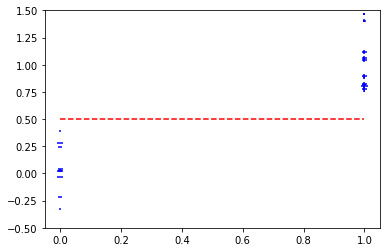

In [20]:
# plt.scatter(y_lime, y_prosty);

plt.scatter(y_lime[y_lime == 0], y_prosty[y_lime == 0],
            c='b', marker='_',s=wagi[y_lime == 0] * 40)
plt.scatter(y_lime[y_lime == 1], y_prosty[y_lime == 1],
            c='b', marker='+', s=wagi[y_lime == 1] * 40)
plt.ylim(-0.5, 1.5);
plt.plot([0,1],[0.5,0.5],color='r', linestyle='dashed');

In [21]:
y_prosty_bin = y_prosty > 0.5

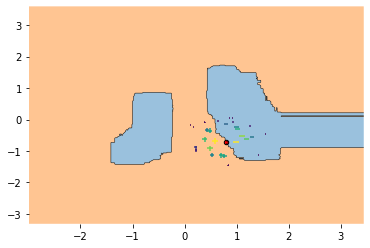

In [22]:
plot_decision_regions(X_lime, y_lime, clf=rf, legend=False,
                      X_highlight=jan,
                      scatter_kwargs=regiony,
                      scatter_highlight_kwargs=obserwacja)
plt.scatter(X_lime[y_prosty_bin == 0, 0], X_lime[y_prosty_bin == 0, 1],
            c=wagi[y_prosty_bin == 0], marker="_", s=wagi[y_prosty_bin == 0]*40)
plt.scatter(X_lime[y_prosty_bin == 1, 0], X_lime[y_prosty_bin == 1, 1],
            c=wagi[y_prosty_bin == 1], marker="+", s=wagi[y_prosty_bin == 1]*40);

### LIME z biblioteką `interpret`

In [23]:
from interpret.blackbox import LimeTabular
from interpret import show

lime_inter = LimeTabular(predict_fn=rf.predict_proba, data=X, random_state=100)

In [3]:
X_przypadki = np.array([[0.8, -0.7],
                        [0.45, 1.4],
                        [0.65, 1.75],
                        [-0.6,0.85]])
y_przypadki = rf.predict(X_przypadki)

print(X_przypadki, y_przypadki)

NameError: name 'rf' is not defined

In [2]:
import numpy as np

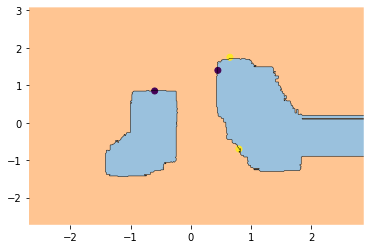

In [27]:
plot_decision_regions(X, y, clf=rf, legend=False,
                      scatter_kwargs=regiony)

plt.scatter(X_przypadki[:,0],X_przypadki[:,1], c=y_przypadki);

In [26]:
inter_lokal = lime_inter.explain_local(
    X_przypadki, y_przypadki, name='lime')
show(inter_lokal)

C:\Users\mateu\anaconda3\lib\site-packages\interpret\visual\udash.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
C:\Users\mateu\anaconda3\lib\site-packages\interpret\visual\udash.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\mateu\anaconda3\lib\site-packages\interpret\visual\udash.py:7: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table as dt


<!-- http://127.0.0.1:7194/2205801142832/ -->

## Zadanie

Proszę przygotować rozwiązanie (program, funkcję, polecenie) w języku Python, które pozwoli na zweryfikowanie istotności predykatorów zmiennej "survived" zbioru Titanic. Należy zbudować klasyfikator wykorzystując jeden z algorytmów typu blackbox a następnie wybrać 4 różne przypadki pasażerów i sprawdzić, które ze zmiennych miały największy wpływ na przypisanie przez klasyfikator etykiety danej klasy.

**Wyniki należy zinterpretować.**

In [55]:
from interpret.blackbox import LimeTabular
from interpret import show
import matplotlib as pyplot

lime_inter = LimeTabular(predict_fn=rf.predict_proba, data=X, random_state=100)

In [59]:
dane = pd.read_csv("titanic.csv", index_col='Unnamed: 0')
dane.shape

(2207, 8)

In [97]:
X = dane[['age', 'class']].values
y = dane['survived'].values

In [1]:
plt.scatter(X[:,0],X[:,1], c=y);

NameError: name 'plt' is not defined

In [100]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
y_hat = rf.predict(X)

In [ ]:
regiony = {'edgecolor': None, 'alpha': 0.0}

<AxesSubplot: >

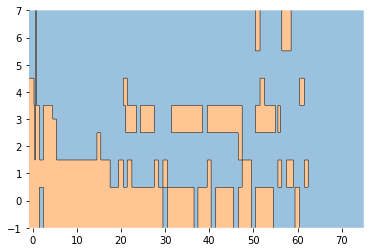

In [101]:
plot_decision_regions(X, y, clf=rf, legend=False,
                      scatter_kwargs=regiony)

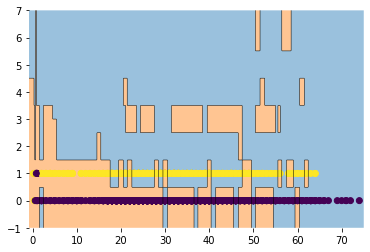

In [102]:
plot_decision_regions(X, y, clf=rf, legend=False,
                      scatter_kwargs=regiony)

plt.scatter(X_przypadkidki[:,0],X_przypadki[:,1], c=y_przypadki);

Interpretacja kazdego przypadku <br>
model zlozonosci moze byc inny niz rf - np. sieci neuronowe <br>
poprawic nazwy zmiennych na wykresie